In [49]:
"""DMD with Control vs Deep Recurrent Koopman (DeReK) comparison for non-linear systems"""

import math
import os
import sys
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

from functions.dmd import DMDwC  # noqa: E402
from functions.preprocessing import hankel, polynomial_extension  # noqa: E402

# Set random seed for reproducibility
np.random.seed(42)

# Define your line styles
line_styles = [
    "-",
    "--",
    "-.",
    ":",
    (0, (3, 1, 1, 1)),
    (0, (5, 5)),
    (0, (3, 5, 1, 5)),
    (0, (3, 10, 1, 10)),
    (0, (5, 1)),
    (0, (5, 10)),
]

# Combine default color cycle with the line styles
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
line_cycler = plt.cycler("color", colors) + plt.cycler(
    "linestyle", line_styles
)

# Apply the combined cycler to the axes
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "CMU Serif",
        "font.serif": "CMU Serif",
        "axes.prop_cycle": line_cycler,
    }
)


def set_size(
    width: float
    | int
    | Literal["article", "ieee", "thesis", "beamer"] = 307.28987,
    fraction=1.0,
    subplots=(1, 1),
):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the height which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "article":
        width_pt = 390.0
    elif width == "ieee":
        width_pt = 252.0
    elif width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = (
        fig_width_in * golden_ratio * ((subplots[0] * fraction) / subplots[1])
    )

    return (fig_width_in * 1.2, fig_height_in * 1.2)


part = 1000

results_path = "results/.dmdc/"
if not os.path.exists(results_path):
    os.makedirs(results_path)


def mae(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.mean(np.abs(Y - Y_pred), axis=0)


def sad(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.sum(np.abs(Y - Y_pred), axis=0)


# Set preprocessing parameters
residuals = True
sqrt = True
degree = 2
hn = 20
r = 0
# Import train data
train_data = pd.read_pickle("data/train_sim.pkl")
noise = np.random.normal(0, 0.1, train_data["X"].shape)
noise = np.zeros(train_data["X"].shape)
X: np.ndarray = (train_data["X"] + noise)[:-1]
U: np.ndarray = train_data["U"][:-1]
# We want Y_k to be X_{k+1}
Y: np.ndarray = (train_data["Y"] + noise)[1:]
n, m = X.shape
# Import test data
test_data = pd.read_pickle("data/test_sim.pkl")
noise_t = np.random.normal(0, 0.1, test_data["X"].shape)
noise_t = np.zeros(test_data["X"].shape)
X_t: np.ndarray = (test_data["X"] + noise_t)[:-1]
U_t: np.ndarray = test_data["U"][:-1]
Y_t: np.ndarray = (test_data["Y"] + noise_t)[1:]
# Import DeReK results
data_derek = sp.io.loadmat(
    "/Users/mw/pyprojects/koopman_dmd_vs_derek/code/results/pred_sim_DeReK.mat"
)
start = 80
y_pred_derek_h1 = data_derek["h1"]
y_pred_derek_h2 = data_derek["h2"]
Y_pred_derek = np.row_stack((y_pred_derek_h1, y_pred_derek_h2)).T[:part]

# Extract non-linear features
if residuals:
    X = np.hstack((X, 1 / X[:, :m]))
    m_feat = m
else:
    m_feat = 0
if sqrt:
    X = np.hstack((X, np.sqrt(X[:, :m])))
    m_feat += m
if degree > 1:
    X = np.hstack((X, polynomial_extension(X[:, :m], degree)))
    m_feat += sum([math.comb(m + r - 1, r) for r in range(2, degree + 1)])
# Extract time-delayed features
X = hankel(X, hn)[hn - 1 :]
U = hankel(U, hn)[hn - 1 :]
Y = Y[hn - 1 :]

if residuals:
    X_t = np.hstack((X_t, 1 / X_t[:, :m]))
if sqrt:
    X_t = np.hstack((X_t, np.sqrt(X_t[:, :m])))
if degree > 1:
    X_t = np.hstack((X_t, polynomial_extension(X_t[:, :m], degree)))
X_t = hankel(X_t, hn)[hn - 1 :][start : part + start]
U_t = hankel(U_t, hn)[hn - 1 :][start : part + start]
Y_t = Y_t[hn - 1 :][start : part + start]

# Set parameters
pred_step = len(Y_t)

# Train DMD model
model = DMDwC(r=r)
model.fit(X, U=U)

MAE and SAD for eDMD:
MAE:  0.4599553941954583
SAD:  459.95539419545827
MAE and SAD for DeReK:
MAE:  0.09622236184775829
SAD:  96.2223618477583


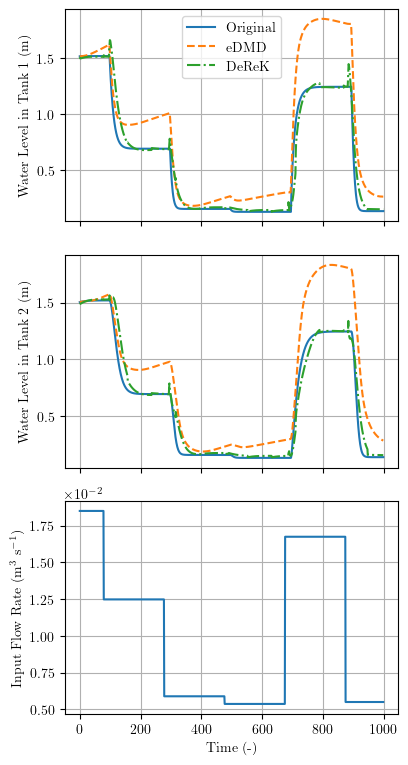

In [50]:
# Perform DMD as multi-step ahead prediction
Y_pred = model.predict(X_t[0, :], U=U_t, forecast=pred_step)
if m_feat > 0:
    Y_pred = Y_pred[:, -Y.shape[1] - m_feat : -m_feat]
else:
    Y_pred = Y_pred[:, -Y.shape[1] :]

# Print MAE and SAD
print("MAE and SAD for eDMD:")
mae_ = mae(Y_t, Y_pred)
print("MAE: ", mae_.sum())
sad_ = sad(Y_t, Y_pred)
print("SAD: ", sad_.sum())

print("MAE and SAD for DeReK:")
mae_ = mae(Y_t, Y_pred_derek)
print("MAE: ", mae_.sum())
sad_ = sad(Y_t, Y_pred_derek)
print("SAD: ", sad_.sum())


# Plot results
fig, axs = plt.subplots(
    3, 1, figsize=set_size("ieee", subplots=(3, 1)), sharex=True
)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for i, (ax, y_t, y_pred, y_derek) in enumerate(
    zip(axs, Y_t.T, Y_pred.T, Y_pred_derek.T), start=1
):
    ax.plot(y_t)
    ax.plot(y_pred)
    ax.plot(y_derek)
    ax.set_ylabel(f"Water Level in Tank {i} " + "$\\mathrm{(m)}$")
    ax.ticklabel_format(style="sci", axis="y", scilimits=(2, 1))
    ax.grid()

axs[2].plot(U_t[:, -1])
axs[2].set_ylabel("Input Flow Rate $\\mathrm{(m^3~s^{-1})}$")
axs[2].set_xlabel("Time (-)")
axs[2].ticklabel_format(style="sci", axis="y", scilimits=(2, 1))
axs[2].grid()

axs[0].legend(["Original", "eDMD", "DeReK"])

fig.tight_layout()
fig.savefig(
    f"{results_path}dmdc_multipred-r{r}-hn{hn}-polydeg{degree}-inv{int(residuals)}{'' if (noise == 0).all() else '-noise'}.pdf"
)

MAE and SAD for each variable:
MAE:  3.7945444683187886e-05
SAD:  0.03794544468318789


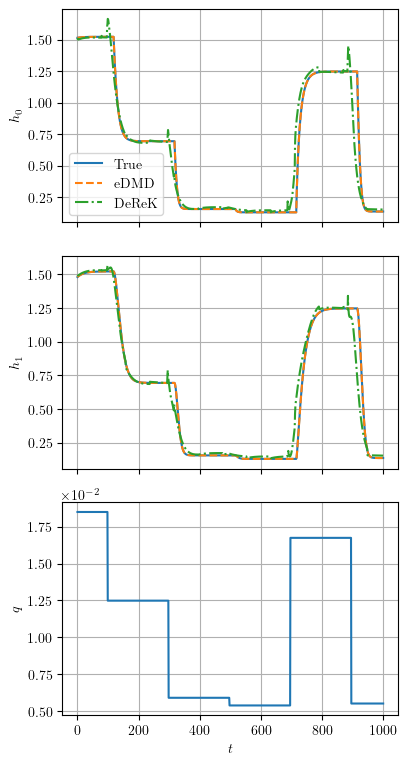

In [14]:
# Perform DMD as one-step ahead prediction
Y_pred = np.zeros((pred_step, Y.shape[1]))
for i in range(pred_step):
    y_pred = model.predict(
        X_t[i, :], U=U_t[i, :].reshape(1, -1), forecast=1
    ).reshape(-1)
    if m_feat > 0:
        y_pred = y_pred[-Y.shape[1] - m_feat : -m_feat]
    else:
        y_pred = y_pred[-Y.shape[1] :]
    Y_pred[i, :] = y_pred

# Print SAD for each variable
print("MAE and SAD for each variable:")
mae_ = mae(Y_t, Y_pred)
print("MAE: ", mae_.sum())
sad_ = sad(Y_t, Y_pred)
print("SAD: ", sad_.sum())

# Plot results
fig, axs = plt.subplots(
    3, 1, figsize=set_size("ieee", subplots=(3, 1)), sharex=True
)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for i, (ax, y_t, y_pred, y_derek) in enumerate(
    zip(axs, Y_t.T, Y_pred.T, Y_pred_derek.T), start=1
):
    ax.plot(y_t)
    ax.plot(y_pred)
    ax.plot(y_derek)
    ax.set_ylabel(f"Water Level in Tank {i} " + "$\\mathrm{(m)}$")
    ax.ticklabel_format(style="sci", axis="y", scilimits=(2, 1))
    ax.grid()

axs[2].plot(U_t[:, -1])
axs[2].set_ylabel("Input Flow Rate $\\mathrm{(m^3~s^{-1})}$")
axs[2].set_xlabel("Time (-)")
axs[2].ticklabel_format(style="sci", axis="y", scilimits=(2, 1))
axs[2].grid()

axs[0].legend(["Original", "eDMD", "DeReK"])

fig.tight_layout()
fig.savefig(
    f"{results_path}dmdc_singlepred-r{r}-hn{hn}-polydeg{degree}-inv{int(residuals)}{'' if (noise == 0).all() else '-noise'}.png"
)